# Softmax classifier (SVM)

In this notebook we implement a softmax classifier for image classification on the CIFAR-10 dataset. Other than the use of the softmax function for the loss functional, this model is basically identical to `02_svm`.

**Technical features:**

* Vectorized loss/gradient models
* Gradient verification via finite differences
* Mini-batch gradient descent
* Hyperparameter tuning

## **Model overview**

* Input: Image $X$, reshaped into an $D$-dimensional vector, here regarded as a column vector as per the linear algebra convention.
    * Caveat: In the code, $X$ is a row vector, so $X$ and other parts of this description may also require transposition when transferring to code.
* Target: Predicted label $y\in \text{labels} = \{1,\ldots,C\}$, where $\text{labels}$ is a set of $C$ classification labels for each image (e.g. "cat", "boat", etc).
* Model parameters:
    * $W\in M_{C\times N}(\mathbb{R})$: a $C\times D$ matrix of weights, regarded as a map $\mathbb{R}^D\to\mathbb{R}^C$.
    * Hyperparameters:
        * $\alpha\in\mathbb{R}_{>0}$: regularization strength. Controls strength of the regularization term $\lambda\|W\|_2^2$.
        * $\epsilon\in\mathbb{R}_{>0}$:  learning rate. Step size for stochastic gradient descent, used during training.
        * $\beta\in\mathbb{N}$: batch size. Sampling size for stochastic gradient descent, used during training.

**Prediction generation algorithm:**

1. Take image $X$ as input.
2. Compute $s(X) = (s(X)_1,\ldots,s(X)_C) = WX \in \mathbb{R}^C$. This vector represents a list of scores for $X$ corresponding to each label in $\text{labels}$. (General SVMs will also have a bias term $b\in\mathbb{R}^C$, so that $s(X) = W\cdot X + b$.)
3. Generate prediction $y$ by taking the label corresponding to the highest score in $s(X)$, i.e. $y = \argmax \{s(X)_i: i=1,\ldots,C\}.$


## **Training**

Training the model consists of generating the matrix of weights $W$ from the training data $\{(X_t,y_t)\}$.

### **1. Construct the loss functional from the training data**

For a given matrix $W$ and a training dataset $\{(X_t,y_t)\}$ (which we regard as fixed), we define the loss functional $\mathcal{L}(W;\{(X_t,y_t)\}) = \mathcal{L}(W)$ as follows:

* For a given image $X$, we set $f(X,W) = s(X,W) = s(X) = WX$ (more generally, $f(X,W) = WX + b$). In particular, $s(X)_y$ is the score of the label $y$ in the image-label pair  $(X,y)$.
* Define the loss functional for the image-label pair $(X,y)$ by the softmax loss function $$L(f(X,W),y) = L(s(X),y) =  -\log\left( \frac{\exp(s(X)_y)}{\sum_j \exp(s(X)_j)} \right) = -s(X)_y + \log \sum_j \exp(s(X)_j).$$
* Define the total loss functional as the average of the loss over the entire training dataset, plus a regularization term: $$\mathcal{L}(W;\{(X_t,y_t)\}) = \frac{1}{N}\sum_{(X_t,y_t)} L(f(X_t,W),y_t) + \alpha R(W)$$
where $N = |\{(X_t,y_t)\}|$, $\alpha$ is the regularization strength, and $R(W) = \|W\|_2^2$ (other functions of $W$ are possible for $R$ too). The regularization helps prevent over-fitting by introducing a data-independent term to the loss.

### **2. Optimize the loss functional in $W$**

Once the loss functional $\mathcal{L}(W;\{(X_t,y_t)\})$ has been constructed from $\{(X_t,y_t)\}$, we regard the training data as fixed and $\mathcal{L}$ as a function of $W$ only: $\mathcal{L} = \mathcal{L}(W)$. We then seek the $W$ that minimizes the average loss, i.e. $$W = \argmin_V \mathcal{L}(V).$$

We accomplish this by gradient descent.

1. Compute the gradient matrix $\nabla_W\mathcal{L}$ by $$[\nabla_W \mathcal{L}]_{ij} = \frac{\partial\mathcal{L}}{\partial W_{ij}};$$ it is a matrix of the same dimensions as $W$.
    
    a. The individual components are given by the following formula:
    $$
        [\nabla_W \mathcal{L}]_{ij} = \frac{1}{N} \sum_{(X_t,y_t)} \left( -\delta_{iy_t} + \frac{\exp(s(X_t)_i)}{\sum_k \exp(s(X_t)_k)} \right)(X_t)_j + 2\alpha W_{ij}.
    $$
    
    b. Equivalently, in matrix form
    $$
        [\nabla_W \mathcal{L}] = \frac{1}{N} \sum_{(X_t,y_t)} X_t\cdot \left( - (\delta_{1y_t},\ldots,\delta_{Cy_t}) + \frac{1}{\sum_k \exp(s(X_t)_k)}(\exp(s(X_t)_1,\ldots,\exp(s(X_t)_C)) \right) + 2\alpha W.
    $$
2. Initialize $W^{(0)}$ as a small random matrix, then define iterates $W_n$ by $$W^{(n+1)} = W^{(n)} -\epsilon(\nabla_W\mathcal{L})(W^{(n)})$$
where $\epsilon$ is the learning rate. Continue iterations until $W^{(n)}$ is sufficiently close to the true minimizer of $\mathcal{L}$.

**Sanity checking with FDM:**

The correctness of the analytic (exact) gradient formulas can be verified by implementing a numerical gradient descent using the finite difference method. However, the finite difference method is expensive in practice, so it should only used for verification and not for training the full model.

**Mini-batching:**

For performance, we add an optimization to this procedure called mini-batching (sometimes also called stochastic gradient descent):

1. Instead of computing the loss functional $\mathcal{L}$ using all of the training data $\{(X_t,y_t)\}$, during each iteration of gradient descent we randomly select a subset $B\subset\{(X_t,y_t)\}$ called a *batch*, then compute the loss functional using only training data $(X_t,y_t)$ selected from $B$.
2. We perform all subsequent gradient and gradient descent calculations during this parameter update using this $\mathcal{L}$.

In practice this usually produces a good enough approximation to gradient descent with the full training data, the idea being that $\mathcal{L}$ is an average and a randomly selected sample of the training data should represent it sufficiently well to reproduce $\mathcal{L}$ on average.

## Hyperparameter tuning:

The model takes the hyperparameters $\epsilon$ (learning rate), $\alpha$ (regularization strength), and $\beta$ (batch size). The provided notebook performs hyperparameter tuning in $\epsilon$ and $\alpha$.

## Performance:

With a good choice of hyperparameters the model can predict labels in the test dataset with ~37% accuracy.


In [1]:
import random
import numpy as np
from model.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from model.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.362079
sanity check: 2.302585


In [4]:
# Complete the model of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from model.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.040462 analytic: 2.040461, relative error: 1.956669e-08
numerical: 1.630193 analytic: 1.630193, relative error: 4.798486e-08
numerical: -1.582015 analytic: -1.582015, relative error: 5.158942e-08
numerical: -2.613596 analytic: -2.613596, relative error: 2.591312e-08
numerical: -3.169512 analytic: -3.169512, relative error: 2.360624e-08
numerical: 0.081552 analytic: 0.081552, relative error: 1.731886e-07
numerical: -3.064133 analytic: -3.064134, relative error: 2.034827e-08
numerical: -0.310771 analytic: -0.310771, relative error: 2.560035e-09
numerical: -1.690132 analytic: -1.690132, relative error: 1.069166e-08
numerical: -1.540406 analytic: -1.540406, relative error: 5.986090e-09
numerical: 0.528572 analytic: 0.528572, relative error: 7.523468e-08
numerical: -4.493325 analytic: -4.493325, relative error: 2.280464e-09
numerical: 0.819618 analytic: 0.819617, relative error: 7.112318e-08
numerical: 0.567721 analytic: 0.567721, relative error: 5.170044e-08
numerical: -1.8483

In [5]:
# Now that we have a naive model of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from model.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
print(loss_vectorized.shape)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.362079e+00 computed in 0.116002s
()
vectorized loss: 1.826058e+00 computed in 0.006968s
Loss difference: 0.536021
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from model.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5.623413e-07]
regularization_strengths = [1.166667e+04]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from copy import deepcopy

for lr in learning_rates:
  for reg in regularization_strengths:
    val_softmax = Softmax()
    val_softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters = 4096, batch_size=512)
    y_train_pred = val_softmax.predict(X_train)
    y_val_pred = val_softmax.predict(X_val)
    tr_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    results.update({tuple([lr,reg]): tuple([tr_acc,val_acc])})
    if val_acc > best_val:
      best_val = val_acc
      best_softmax = deepcopy(val_softmax)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.623413e-07 reg 1.166667e+04 train accuracy: 0.352755 val accuracy: 0.362000
best validation accuracy achieved during cross-validation: 0.362000


In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


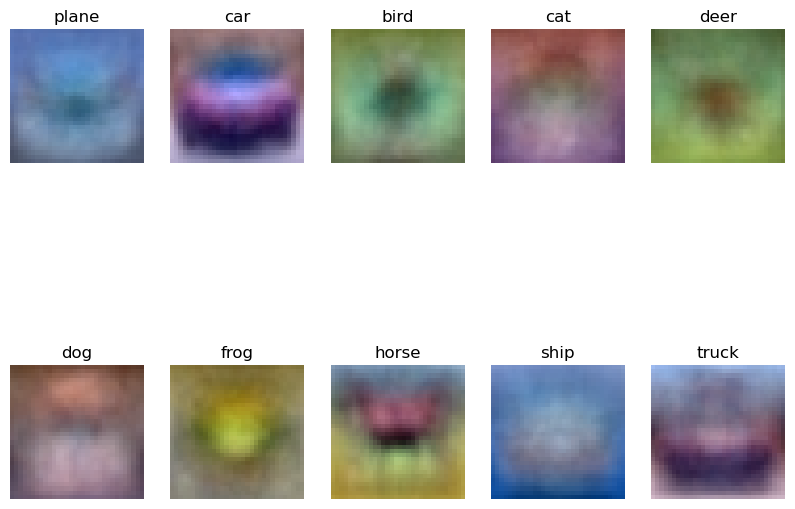

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])